In [1]:
import sys
# to import local fuctions
sys.path.insert(0, '../tools')
import pandas as pd
import time

import itertools
import random

from datetime import timedelta
import numpy as np
from matplotlib import pyplot as plt

from signals.create_signals import main_signals
from run_all import main

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

# Running Full Script

In [10]:
# Run for all stocks
#trades = main()

# If you want to run it on a small pool of stocks
trades = main(full_refresh=True, export_indicators=False)

1764 stocks will be analyzed

Running Price Full Refresh
Elapsed: 43.88s

Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Running indicators ...
Elapsed: 11.32 mins

Add Fundamentals
Elapsed: 1.50 mins

Create Buy/Sell Signals
Elapsed: 1.96 mins

The whole process took 15.5 minutes. Happy Trading! =)


In [ ]:
trades['buy_signal?6']

In [55]:
for i in trades['symbol'].unique():
    if i not in trades[trades['buy_signal?6'] == True]['symbol'].unique():
        print(i)

BIO-B
BRK-A
NGHCP
GLIBP
NYMTP
NYMTO
SLMBP
NGHCO
CFXA
ANAT
NGHCN
ACGLO
PHI
FCNCA
BAK
WTM
AIZP
GSH
Y
UHAL
HBANO
CHE
HNP
BBDO
JHX
BHFAP
LN
BIPC
FSV
TPL
SHI
CEA
NEU
TARO
CHT
BBU
COKE
MKL
ZNH
USM
ESLT
IEP
BF-A
AGNCM
IX
STRA
DCUE
GFNCP
CEO
EBR-B
NFE
UNF
MORN
ARD
SEB
PTR
NVR
ACGLP
IFS
MOR
TFII
NYMTN
AGNCN
CWEN-A
SAFE
ESGR
STN
SAM
CBPO
WF
CABO
FELE
SCL
HELE
TKC
COHR
KOF
WDFC
ERIE
WPP
WTS
HLNE
LFUS
PAC
NOVT
ESE
TREE
GSHD
ICL
TIGO
PSB
BATRA
GLPG
NAC
JBT
BCPC
LBRDA
SKM
CACI
AIT
SHEN
BGNE
ITGR
FIZZ
MANU
INDB
ATHM
MANT
LCII
KWR
CNS
RDY
BCH
CCU
UI
DAO
SHG
FIBK
SNP
ASR
DORM
MTD
FMS
JW-A
NEP
PEGA
JJSF
ICUI
DSGX
GTES
KNSL
AWR
PEN
CW
NICE
DAVA
MKSI
VICR
OMCL
CHA
VVNT
APPF
ALLK
KEP
KB
CHH
OPCH
PRI
ROG
VIE
LECO
CASY
ROLL
AAON
BSAC
THG
RBC
AEIS
SNX
NGHC
TECH
EXLS
VMI
MSGS
MEDP
TSEM
ARGX
ATR
STMP
GIB
REYN
AMG
CIGI
CCOI
GWW
SFBS
DIOD
LPL
TLK
WK
KOD
MPWR
UTF
LANC
ORA
HCM
LSTR
ACH
AZO
LOPE
CSGP
SATS
PSN
DCPH
KMPR
LAD
JOBS
SUN
CWST
FOCS
TFSL
TM
NTCT
AIN
UFPI
BIO
DEO
NVRO
CP
SYNA
ATRC
CALM
EME
NSP
CLH
RETA
COLM


In [56]:
trades[trades['buy_signal?6'] == True]['symbol'].unique()

array(['CQP', 'ALTR', 'POWI', 'TDY', 'FDS', 'ASND', 'MSA', 'WSO', 'CCMP',
       'BRC', 'CWT', 'IBOC', 'FN', 'IDA', 'CMPR', 'SR', 'NEOG', 'RLI',
       'SIGI', 'MKTX', 'PKX', 'SAIA', 'SWX', 'GATX', 'SSD', 'EVTC', 'CNA',
       'ENV', 'UMBF', 'ENS', 'ICLR', 'FICO', 'OGS', 'CBU', 'EPAY', 'BOH',
       'PNM', 'MRCY', 'COO', 'ASGN', 'B', 'SAFM', 'LHCG', 'KRTX', 'PRLB',
       'TTEK', 'MUSA'], dtype=object)

In [24]:
bench_returns = []
for i in [10, 20, 30, 60, 90, 120, 150, 180]:
    a = f'{i}d_return_S&P Benchmark_close_price'
    b = f'moving_{i}d_return'
    bench_returns.append([a,b])
    
for idx, i in enumerate([10, 20, 30, 60, 90, 120, 150, 180]):
    trades[f'{i}_above_bench'] = False
    print(bench_returns[idx][0])
    trades[f'{i}_above_bench'].mask(trades[bench_returns[idx][1]] > (trades[bench_returns[idx][0]] * 1.2), True, inplace=True)
    


10d_return_S&P Benchmark_close_price
20d_return_S&P Benchmark_close_price
30d_return_S&P Benchmark_close_price
60d_return_S&P Benchmark_close_price
90d_return_S&P Benchmark_close_price
120d_return_S&P Benchmark_close_price
150d_return_S&P Benchmark_close_price
180d_return_S&P Benchmark_close_price


In [25]:
trades[trades['60_above_bench'] == True][['timestamp', 'symbol', '60d_return_S&P Benchmark_close_price', 'moving_60d_return']]

,timestamp,symbol,60d_return_S&P Benchmark_close_price,moving_60d_return
585,2018-05-22 13:30:00,BIO-B,0.980964,1.197726
586,2018-05-23 13:30:00,BIO-B,0.996101,1.197726
795,2019-03-25 13:30:00,BIO-B,1.133480,1.426244
796,2019-03-26 13:30:00,BIO-B,1.133228,1.389024
801,2019-04-02 13:30:00,BIO-B,1.133048,1.372291
...,...,...,...,...
342574,2019-08-21 13:30:00,BLKB,1.043905,1.263794
342575,2019-08-22 13:30:00,BLKB,1.050634,1.262046
344775,2018-12-20 14:30:00,VPU,0.850112,1.037575
344776,2018-12-21 14:30:00,VPU,0.830344,1.040997


In [37]:
trades[(trades['symbol'] == 'BIO-B') & (trades['60_above_bench'] == True)][['daily_return']]

,daily_return
585,1.072532
586,1.000000
795,1.000000
796,1.000000
801,1.000000
1041,1.000000
1043,1.000000
1045,1.000000
1046,0.994906
1053,1.000000


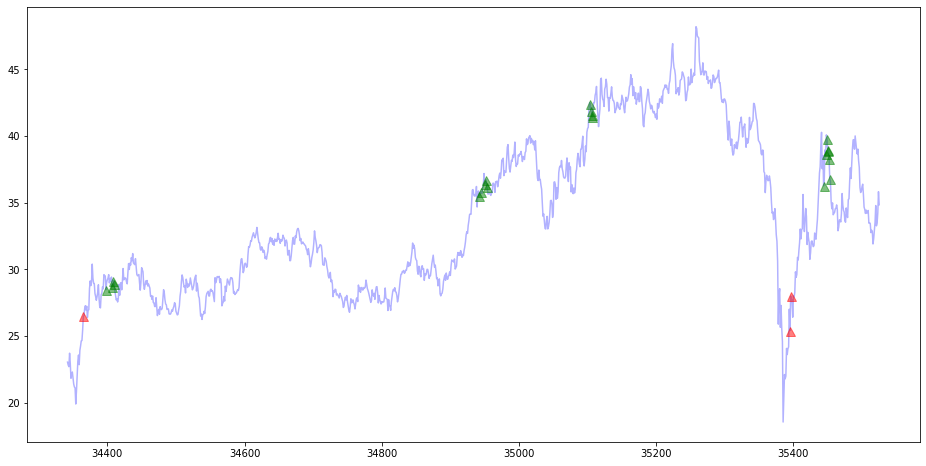

In [57]:
trades[trades['symbol'] == 'CQP']['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.3)
trades[(trades['symbol'] == 'CQP') & (trades['60_above_bench'] == True) & (trades['daily_return'] < 1)]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
trades[(trades['symbol'] == 'CQP') & (trades['10_above_bench'] == True)]['close_price_x'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')

Testing

In [179]:
# Create Placeholders
trades['placeholder_1'] = True
trades['placeholder_2'] = True
trades['placeholder_3'] = True
trades['placeholder_4'] = True
trades['placeholder_5'] = True

# List with all signals
signals = list(trades.columns[378:][:164])
signals.append('placeholder_1')

# Clean list
to_remove = []
for i in signals:
    if ('next_' in i) or ('close_price' in i) or ('benchmark' in i) or ('volume_traded' in i):
        to_remove.append(i)

signals = set(signals) - set(to_remove)

# All possible combinations
combinations = [i for i in itertools.combinations(signals, 1)]

In [180]:
combinations

[('sma_50_zscore_cross_3std',),
 ('bb_bbm_cross_down',),
 ('bb_buy_zone_3d',),
 ('rsi_bins_60_cross_down',),
 ('rsi_bins_70_cross_down',),
 ('rsi_bins_cross_up_210_avg_minus_std2',),
 ('sma_10_50_cross',),
 ('rsi_bullish_divergence_20d',),
 ('rsi_bins_40_cross_down',),
 ('rsi_bins_cross_down_140_avg_plus_std1',),
 ('rsi_bins_cross_up_70_avg',),
 ('rsi_bins_cross_up_140_avg_minus_std1',),
 ('rsi_bearish_divergence_15d',),
 ('rsi_bins_cross_up_105_avg_minus_std1',),
 ('rsi_bins_20_cross_down',),
 ('bb_bbh_cross_down',),
 ('lower_lows_4d',),
 ('rsi_bins_cross_up_35_avg_minus_std1',),
 ('rsi_bins_cross_up_35_avg_plus_std1',),
 ('rsi_bins_cross_down_175_avg_plus_std1',),
 ('bb_buy_zone_6d',),
 ('rsi_bins_cross_up_70_avg_minus_std2',),
 ('macd_bullish_divergence_20d',),
 ('sma_50_200_cross',),
 ('sma_100_crossover',),
 ('lower_lows_3d_end',),
 ('rsi_bins_cross_up_70_avg_plus_std1',),
 ('rsi_bins_cross_up_35_avg_minus_std2',),
 ('bb_bbh_cross_up',),
 ('sma_20_100_cross',),
 ('rsi_bins_cross_d

In [148]:
# Create list of test symbols
symbols = trades['symbol'].unique()
test_symbols = []
for i in range(1000):
    test_symbols.append(random.choice(symbols))
if 'TT' in test_symbols:
    test_symbols.remove('TT')
test_symbols = set(test_symbols)
clean_df = trades[trades['symbol'].isin(test_symbols)]
clean_df = clean_df[clean_df['volume_traded_filter'] == True]

In [183]:
results_lst = []

pairs = []

# For every pair in 100 good pairs we found
for pair in pairs_signals:
    
    # Extract buy and sell
    buy = pair[0][0]
    sell = pair[1][0]
    
    # Print pair and start recording time
    print(pair)
    start = time.time()
    
    # Define dataframes
    clean_buy = clean_df[clean_df[buy] == True]
    clean_sell = clean_df[clean_df[sell] == True]
    
    # For buy signals in combinations
    for buy_signals in combinations:

        # Extract signal
        buy_signal_1 = buy_signals[0]
        #buy_signal_2 = buy_signals[1]

        # if signals are different
        if buy_signal != buy:

            # Define buys
            buys = clean_buy[(clean_buy[buy_signal_1] == True)][['symbol', 'just_date', 'close_price_x']]
            buys.columns = ['symbol', 'buy_date', 'buy_price']
            buys['key'] = 0
            no_buys = len(buys)
            
            # There are any buys we continue
            if no_buys != 0:
                
                # For sell signals in combinations
                for sell_signals in combinations:
                    
                    # Extract signal
                    sell_signal_1 = sell_signals[0]
                    #sell_signal_2 = sell_signals[1]
                    
                    # Create two lists with both signals in both sides
                    clean_buy_signals = set([buy, buy_signal_1])
                    clean_sell_signals = set([sell, sell_signal_1])
                    
                    # If len of set is 4 then all elements are different and if not in pairs, then it was not analyzed yet
                    if (len(set([buy, sell, buy_signal_1, sell_signal_1])) == 4) & ([clean_buy_signals, clean_sell_signals] not in pairs):

                        # Define sells
                        sells = clean_sell[(clean_sell[sell_signal_1] == True)][['symbol', 'just_date', 'close_price_x']]
                        sells.columns = ['symbol', 'sell_date', 'sell_price']
                        sells['key'] = 0
                        no_sells = len(sells)
                        
                        # If there are any sells at all we continue
                        if no_sells != 0:

                            # Combine them - merge on dummy column and symbol, so we get all possible combinations
                            results = pd.merge(buys, sells, on=['symbol', 'key'])
                            
                            # If no results, then we don't care
                            if len(results) == 0:

                                winners = 0
                                losers = 0
                                gain_mean = 0
                                gain_std = 0
                                gain_winner_mean = 0
                                gain_winner_std = 0
                                gain_loss_mean = 0
                                gain_loss_std = 0

                            else:
                                
                                # Calculate different between buy date and sell date
                                results['difference'] = (results['buy_date'] - results['sell_date']).dt.days

                                # Keep first on list, which will be the correct sell
                                analysis = results[results['difference'] < 0].drop_duplicates(subset=['symbol', 'buy_date'], keep='first')

                                # Calculate Gain and metrics
                                analysis['gain'] = (analysis['sell_price'] / analysis['buy_price']) - 1
                                gain_mean = analysis['gain'].mean()
                                gain_std = analysis['gain'].std()
                                
                                # Create winner boolean field
                                analysis['winner'] = analysis['gain'] > 0
                                win = analysis[analysis['winner'] == True]
                                loss = analysis[analysis['winner'] == False]
                                gain_winner_mean = win['gain'].mean()
                                gain_winner_std = win['gain'].std()
                                gain_loss_mean = loss['gain'].mean()
                                gain_loss_std = loss['gain'].std()
                                
                                # Total Winners and losers
                                winners = analysis['winner'].sum()
                                losers = len(analysis) - winners
                            
                            # Append results in list
                            results_lst.append([clean_buy_signals, clean_sell_signals, 
                                                no_buys, no_sells, 
                                                winners, losers, 
                                                gain_mean, gain_std,
                                                gain_winner_mean, gain_winner_std,
                                                gain_loss_mean, gain_loss_std])

                            # Append pairs
                            pairs.append([clean_buy_signals, clean_sell_signals])

                        else:
                            continue
            else:
                continue

    end = time.time()

    print(end-start)

[['rsi_bins_cross_up_35_avg_plus_std1', ''], ['rsi_bins_80_cross_up', '']]
369.0918159484863
[['rsi_bins_cross_up_105_avg', ''], ['rsi_bins_80_cross_up', '']]
308.06608986854553
[['rsi_bins_cross_up_70_avg', ''], ['rsi_bins_80_cross_up', '']]
325.51029992103577
[['rsi_bins_cross_down_35_avg_minus_std1', ''], ['rsi_bins_80_cross_up', '']]
360.59818506240845
[['rsi_bins_cross_down_70_avg', ''], ['rsi_bins_80_cross_up', '']]
369.4050109386444
[['rsi_bins_cross_up_35_avg', ''], ['rsi_bins_80_cross_up', '']]
415.33860182762146
[['rsi_bins_cross_down_35_avg_minus_std1', ''], ['rsi_bins_80_cross_down', '']]
434.9234309196472
[['rsi_bins_cross_down_35_avg', ''], ['rsi_bins_80_cross_up', '']]
483.4935688972473
[['rsi_bins_cross_down_70_avg', ''], ['rsi_bins_80_cross_down', '']]
476.29025506973267
[['rsi_bins_cross_up_70_avg', ''], ['rsi_bins_80_cross_down', '']]
522.8911678791046
[['rsi_bins_cross_down_35_avg', ''], ['rsi_bins_80_cross_down', '']]
531.6825540065765
[['rsi_bins_cross_up_35_avg',

In [177]:
pairs

[[{'bb_buy_zone_3d',
   'rsi_bins_cross_up_35_avg_plus_std1',
   'sma_50_zscore_cross_3std'},
  {'rsi_bins_80_cross_up', 'rsi_bins_cross_up_70_avg', 'sma_10_50_cross'}],
 [{'bb_buy_zone_3d',
   'rsi_bins_cross_up_35_avg_plus_std1',
   'sma_50_zscore_cross_3std'},
  {'rsi_bins_80_cross_up',
   'rsi_bins_cross_up_140_avg_minus_std1',
   'sma_10_50_cross'}],
 [{'bb_buy_zone_3d',
   'rsi_bins_cross_up_35_avg_plus_std1',
   'sma_50_zscore_cross_3std'},
  {'rsi_bins_80_cross_up',
   'rsi_bins_cross_up_105_avg_minus_std1',
   'sma_10_50_cross'}],
 [{'bb_buy_zone_3d',
   'rsi_bins_cross_up_35_avg_plus_std1',
   'sma_50_zscore_cross_3std'},
  {'rsi_bins_80_cross_up',
   'rsi_bins_cross_up_35_avg_minus_std1',
   'sma_10_50_cross'}],
 [{'bb_buy_zone_3d',
   'rsi_bins_cross_up_35_avg_plus_std1',
   'sma_50_zscore_cross_3std'},
  {'macd_bullish_divergence_20d', 'rsi_bins_80_cross_up', 'sma_10_50_cross'}],
 [{'bb_buy_zone_3d',
   'rsi_bins_cross_up_35_avg_plus_std1',
   'sma_50_zscore_cross_3std'},


In [184]:
pd.DataFrame(results_lst, columns = ['buy', 'sell', 'no_buys', 'no_sells', 'winners', 'losers',
                                            'gain_mean', 'gain_std','gain_winner_mean', 'gain_winner_std',
                                            'gain_loss_mean', 'gain_loss_std' ]).to_csv('reno5.csv', index=0)

Best Pairs

In [96]:
analysis = pd.read_csv('reno2.csv')
analysis['buys'] = analysis['buys'].str.replace("'",'').apply(lambda x: x[1:-1].split(','))
analysis['sells'] = analysis['sells'].str.replace("'",'').apply(lambda x: x[1:-1].split(','))

pairs_signals = []

analysis['win_ratio'] = analysis['winners'] / (analysis['winners'] + analysis['losers'])
analysis = analysis[(analysis['win_ratio'] > 0.75) & 
                    (analysis['winners'] >  15000) & 
                    (~analysis['buys'].astype(str).str.contains('funda')) &
                    (~analysis['buys'].astype(str).str.contains('buy_zone')) &
                    (~analysis['buys'].astype(str).str.contains('price_above')) &
                    (~analysis['buys'].astype(str).str.contains('macd')) &
                    (~analysis['buys'].astype(str).str.contains('higher')) &
                    (~analysis['buys'].astype(str).str.contains('lower')) &
                    (~analysis['buys'].astype(str).str.contains('eps')) &
                    (~analysis['buys'].astype(str).str.contains('divergence')) &
                    (~analysis['buys'].astype(str).str.contains('market_cap')) &
                    (~analysis['sells'].astype(str).str.contains('funda')) &
                    (~analysis['sells'].astype(str).str.contains('buy_zone')) &
                    (~analysis['sells'].astype(str).str.contains('price_above')) &
                    (~analysis['sells'].astype(str).str.contains('macd')) &
                    (~analysis['sells'].astype(str).str.contains('higher')) &
                    (~analysis['sells'].astype(str).str.contains('lower')) &
                    (~analysis['sells'].astype(str).str.contains('eps')) &
                    (~analysis['sells'].astype(str).str.contains('divergence')) &
                    (~analysis['sells'].astype(str).str.contains('market_cap'))]

top_signals = analysis.sort_values('win_ratio', ascending=False).head(50)[['buys','sells']]
pairs_signals = []
for row in top_signals.iterrows():
    pairs_signals.append([row[1]['buys'], row[1]['sells']])

In [39]:
for idx, pairs in enumerate(pairs_signals):
    print(idx, pairs)

0 [['rsi_bins_60_cross_down', 'bb_buy_zone_3d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
1 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_70_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
2 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_70_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
3 [['rsi_bins_60_cross_down', 'bb_buy_zone_6d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
4 [['rsi_bins_60_cross_down', 'bb_buy_zone_6d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
5 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
6 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'placeholder_1']]
7 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
8 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['price_above_sma_10', 'rsi_bins_60_cross_up']]
9 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'price_above_sma

In [8]:
dfff = pd.read_csv('reno5.csv')
dfff['win/buys'] = dfff['winners'] / dfff['no_buys']
dfff['win_ratio_trades'] = dfff['winners'] / (dfff['winners'] + dfff['losers'])
dfff['gain_mean/std'] = dfff['gain_mean'] / dfff['gain_std']
dfff['gain_win/loss'] = dfff['gain_winner_mean'] / dfff['gain_loss_mean'].abs()

signals_df = dfff[(dfff['no_buys'] > 1000) &
                 (dfff['win_ratio_trades'] > 0.9) &
                 (dfff['win/buys'] > 0.6) &
                 (dfff['no_buys'] < dfff['no_sells']) &
                 (dfff['gain_mean/std'] > 0.6) &
                 (dfff['gain_winner_mean'] > dfff['gain_loss_mean'].abs())].sort_values('win_ratio_trades', ascending=False)[['buy', 'sell']]

pair_signals = []
for row in signals_df.iterrows():
    tmp = []
    tmp.append(row[1]['buy'][2:-2].replace("'","").replace(" ","").split(','))
    tmp.append(row[1]['sell'][2:-2].replace("'","").replace(" ","").split(','))
    pair_signals.append(tmp)
    
trades['placeholder_1'] = True

In [11]:
dfff = pd.read_csv('reno5.csv')
dfff['win/buys'] = dfff['winners'] / dfff['no_buys']
dfff['win_ratio_trades'] = dfff['winners'] / (dfff['winners'] + dfff['losers'])
dfff['gain_mean/std'] = dfff['gain_mean'] / dfff['gain_std']
dfff['gain_win/loss'] = dfff['gain_winner_mean'] / dfff['gain_loss_mean'].abs()

signals_df = dfff[(dfff['no_buys'] > 500) & (dfff['win/buys'] > 0.85)]

pair_signals = []
for row in signals_df.iterrows():
    tmp = []
    tmp.append(row[1]['buy'][2:-2].replace("'","").replace(" ","").split(','))
    tmp.append(row[1]['sell'][2:-2].replace("'","").replace(" ","").split(','))
    pair_signals.append(tmp)

trades['placeholder_1'] = True

In [12]:
for idx, pairs in enumerate(pair_signals):
    
    # get signals
    buy_signal = pairs[0][0]
    buy_signal_2 = pairs[0][1]
    sell_signal = pairs[1][0]
    sell_signal_2 = pairs[1][1]
    
    # create columns
    trades[f'buy_signal_auto_{idx}'] = False
    trades[f'sell_signal_auto_{idx}'] = False
    
    # create signals in dataframe
    trades[f'buy_signal_auto_{idx}'].mask((trades[buy_signal] == True) &
                                          (trades[buy_signal_2] == True) &
                                          #(trades[buy_signal].all(axis=1,skipna=True) == True) &
                                          (trades['volume_traded_filter'] == True), True, inplace=True)

    trades[f'sell_signal_auto_{idx}'].mask((trades[sell_signal] == True) &
                                           #(trades[sell_signal].all(axis=1,skipna=True) == True
                                           (trades[sell_signal_2] == True), True, inplace=True)
        
    
    print(pairs)

[['rsi_bins_60_cross_down', 'bb_buy_zone_3d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
[['rsi_bins_60_cross_down', 'rsi_bins_cross_up_70_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
[['rsi_bins_60_cross_down', 'rsi_bins_cross_up_70_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
[['rsi_bins_60_cross_down', 'bb_buy_zone_6d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
[['rsi_bins_60_cross_down', 'bb_buy_zone_6d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
[['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
[['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'placeholder_1']]
[['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
[['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['price_above_sma_10', 'rsi_bins_60_cross_up']]
[['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'price_above_sma_20']]
[['rsi_bins_6

In [13]:
for idx, pairs in enumerate(pair_signals):
    print(idx, pairs)

0 [['rsi_bins_60_cross_down', 'bb_buy_zone_3d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
1 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_70_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
2 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_70_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
3 [['rsi_bins_60_cross_down', 'bb_buy_zone_6d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
4 [['rsi_bins_60_cross_down', 'bb_buy_zone_6d'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
5 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_3d']]
6 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'placeholder_1']]
7 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'bb_buy_zone_4d']]
8 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['price_above_sma_10', 'rsi_bins_60_cross_up']]
9 [['rsi_bins_60_cross_down', 'rsi_bins_cross_up_35_avg'], ['rsi_bins_60_cross_up', 'price_above_sma

In [14]:
signals_df.head()

,buy,sell,no_buys,no_sells,winners,losers,gain_mean,gain_std,gain_winner_mean,gain_winner_std,gain_loss_mean,gain_loss_std,win/buys,win_ratio_trades,gain_mean/std,gain_win/loss
209372,"{'rsi_bins_60_cross_down', 'bb_buy_zone_3d'}","{'rsi_bins_60_cross_up', 'bb_buy_zone_4d'}",21928,15001,18847,1963,0.031137,0.108891,0.048878,0.088192,-0.139194,0.137827,0.859495,0.905670,0.285952,0.351152
210125,"{'rsi_bins_60_cross_down', 'rsi_bins_cross_up_...","{'rsi_bins_60_cross_up', 'bb_buy_zone_3d'}",505,18200,435,45,0.028894,0.114523,0.048087,0.084612,-0.156642,0.182530,0.861386,0.906250,0.252296,0.306988
210165,"{'rsi_bins_60_cross_down', 'rsi_bins_cross_up_...","{'rsi_bins_60_cross_up', 'bb_buy_zone_4d'}",505,15001,430,45,0.037230,0.140535,0.057848,0.117894,-0.159784,0.182746,0.851485,0.905263,0.264916,0.362037
211254,"{'rsi_bins_60_cross_down', 'bb_buy_zone_6d'}","{'rsi_bins_60_cross_up', 'bb_buy_zone_3d'}",19434,18200,16964,1662,0.026753,0.097206,0.042560,0.076656,-0.134589,0.131697,0.872903,0.910770,0.275217,0.316220
211294,"{'rsi_bins_60_cross_down', 'bb_buy_zone_6d'}","{'rsi_bins_60_cross_up', 'bb_buy_zone_4d'}",19434,15001,16737,1706,0.031498,0.108983,0.048900,0.089228,-0.139223,0.134846,0.861223,0.907499,0.289019,0.351233


In [15]:
x = main_signals(trades)

Create Buy/Sell Signals


In [9]:
x[(x['buy_signal?6'] == True)].groupby('just_date').count()['symbol']

just_date
2016-05-11     60
2016-05-12     67
2016-05-13    221
2016-05-16     62
2016-05-17    178
             ... 
2020-08-26     67
2020-08-27    148
2020-08-28    102
2020-08-31    169
2020-09-01    187
Name: symbol, Length: 1086, dtype: int64

In [7]:
tt = trades[(trades['rsi_bins_cross_down_140_avg_minus_std2'] == True) & 
            (trades['volume_traded_filter'] == True) &
           (trades['bb_bbm_cross_down'] == True)]

In [8]:
tt.groupby('just_date').count()['symbol'].sort_values()

just_date
2018-06-01      1
2018-06-08      1
2018-06-11      1
2018-07-10      1
2018-07-19      1
2018-07-23      1
2018-08-20      1
2018-08-24      1
2018-08-27      1
2018-08-31      1
2018-09-18      1
2018-10-18      1
2018-10-31      1
2018-11-05      1
2018-11-07      1
2018-11-08      1
2018-11-19      1
2018-11-23      1
2018-11-27      1
2018-11-28      1
2018-12-12      1
2019-01-04      1
2019-01-09      1
2019-01-10      1
2019-01-29      1
2019-01-31      1
2019-02-01      1
2019-02-04      1
2018-06-06      1
2018-06-05      1
2018-05-18      1
2018-05-17      1
2017-03-16      1
2017-03-28      1
2017-03-29      1
2017-03-30      1
2017-05-22      1
2017-05-23      1
2017-06-01      1
2017-06-02      1
2017-07-11      1
2017-07-12      1
2017-07-13      1
2017-07-14      1
2017-07-17      1
2019-02-06      1
2017-11-22      1
2018-01-08      1
2018-01-16      1
2018-01-19      1
2018-02-13      1
2018-03-06      1
2018-03-12      1
2018-03-15      1
2018-03-21      1


In [272]:
dist = []

for idx, x in enumerate(pairs_signals):
    print(x)
    buys = clean_df[(clean_df[x[0]] == True)][['symbol', 'just_date', 'close_price_x']]
    buys.columns = ['symbol', 'buy_date', 'buy_price']
    buys['key'] = 0

    sells = clean_df[(clean_df[x[1]] == True)][['symbol', 'just_date', 'close_price_x']]
    sells.columns = ['symbol', 'sell_date', 'sell_price']
    sells['key'] = 0

    # Combine them - merge on dummy column and symbol, so we get all possible combinations
    results = pd.merge(buys, sells, on=['symbol', 'key'])

    results['difference'] = (results['buy_date'] - results['sell_date']).dt.days

    # Keep first on list, which will be the correct sell
    analysis = results[results['difference'] < 0].drop_duplicates(subset=['symbol', 'buy_date'], keep='first')
    analysis = analysis.drop_duplicates(subset=['symbol', 'sell_date'], keep='first')
    
    analysis['%_gain'] = (analysis['sell_price'] / analysis['buy_price']) - 1
    analysis['signal'] = str(x)
    
    if idx == 0:
        to_export = analysis.copy()
    else:
        to_export = pd.concat([to_export, analysis])
    
    for i in ['%_gain', 'difference']:
        metric = list(analysis[i].describe().values)
        metric.append(i)
        metric.append(x)
        dist.append(metric)

['rsi_bins_cross_up_35_avg_plus_std1', 'rsi_bins_80_cross_up']
['rsi_bins_cross_up_105_avg', 'rsi_bins_80_cross_up']
['rsi_bins_cross_up_70_avg', 'rsi_bins_80_cross_up']
['rsi_bins_cross_down_35_avg_minus_std1', 'rsi_bins_80_cross_up']
['rsi_bins_cross_down_70_avg', 'rsi_bins_80_cross_up']
['rsi_bins_cross_up_35_avg', 'rsi_bins_80_cross_up']
['rsi_bins_cross_down_35_avg_minus_std1', 'rsi_bins_80_cross_down']
['rsi_bins_cross_down_35_avg', 'rsi_bins_80_cross_up']
['rsi_bins_cross_down_70_avg', 'rsi_bins_80_cross_down']
['rsi_bins_cross_up_70_avg', 'rsi_bins_80_cross_down']
['rsi_bins_cross_down_35_avg', 'rsi_bins_80_cross_down']
['rsi_bins_cross_up_35_avg', 'rsi_bins_80_cross_down']
['rsi_bins_60_cross_up', 'bb_bbh_cross_up']
['bb_bbm_cross_up', 'bb_bbh_cross_up']
['sma_10_20_cross', 'bb_bbh_cross_up']
['rsi_bins_60_cross_down', 'bb_bbh_cross_up']
['rsi_bins_cross_up_210_avg', 'bb_bbh_cross_up']
['rsi_bins_cross_up_35_avg_plus_std1', 'rsi_bins_80_cross_down']
['rsi_bins_cross_down_35_av

In [273]:
to_export.to_csv('chart_signals.csv', index=0)

In [274]:
metrics = pd.DataFrame(dist, columns = ['count', 'mean', 'std', 'min', '25', '50', '75', 'max', 'metric', 'signals'])
metrics['signals'] = metrics['signals'].astype(str)
metrics['return_risk_ratio'] = metrics['mean'] / metrics['std']
gainz = metrics[metrics['metric'] == '%_gain']
gainz

,count,mean,std,min,25,50,75,max,metric,signals,return_risk_ratio
0,3221.0,0.200514,0.371241,-0.810207,0.014728,0.099921,0.287998,5.161746,%_gain,"['rsi_bins_cross_up_35_avg_plus_std1', 'rsi_bi...",0.540117
2,2047.0,0.249839,0.373126,-0.857836,0.077130,0.184171,0.351554,4.226631,%_gain,"['rsi_bins_cross_up_105_avg', 'rsi_bins_80_cro...",0.669583
4,2193.0,0.248275,0.387899,-0.856977,0.068512,0.175509,0.347873,5.161746,%_gain,"['rsi_bins_cross_up_70_avg', 'rsi_bins_80_cros...",0.640051
6,2095.0,0.286563,0.417006,-0.836827,0.099035,0.211460,0.404471,4.878136,%_gain,"['rsi_bins_cross_down_35_avg_minus_std1', 'rsi...",0.687192
8,2072.0,0.277559,0.425910,-0.836827,0.095047,0.201630,0.382582,6.517619,%_gain,"['rsi_bins_cross_down_70_avg', 'rsi_bins_80_cr...",0.651685
10,2438.0,0.245229,0.381627,-0.797134,0.050135,0.167449,0.360282,4.149176,%_gain,"['rsi_bins_cross_up_35_avg', 'rsi_bins_80_cros...",0.642587
12,2156.0,0.276383,0.415251,-0.839215,0.084759,0.205236,0.396553,4.885305,%_gain,"['rsi_bins_cross_down_35_avg_minus_std1', 'rsi...",0.665579
14,2222.0,0.285876,0.413904,-0.791411,0.095509,0.209011,0.408033,4.878136,%_gain,"['rsi_bins_cross_down_35_avg', 'rsi_bins_80_cr...",0.690683
16,2160.0,0.264259,0.416282,-0.839215,0.073912,0.193439,0.374284,5.214957,%_gain,"['rsi_bins_cross_down_70_avg', 'rsi_bins_80_cr...",0.634808
18,2108.0,0.255695,0.392086,-0.859070,0.075305,0.188232,0.362177,4.448148,%_gain,"['rsi_bins_cross_up_70_avg', 'rsi_bins_80_cros...",0.652140


In [275]:
dayz = metrics[metrics['metric'] == 'difference']

In [276]:
annual = pd.merge(gainz[['signals', 'mean']], dayz[['signals', 'mean']], on='signals')
annual['annualized'] = ((1 + annual['mean_x']) ** (365/annual['mean_y'].abs())) - 1
annual.columns = ['signals', 'mean_return', 'mean_hold', 'annualized_return']
metrics = pd.merge(metrics, annual[['signals', 'annualized_return']], on='signals')
metrics[metrics['metric'] == '%_gain'].sort_values('return_risk_ratio', ascending=False)

,count,mean,std,min,25,50,75,max,metric,signals,return_risk_ratio,annualized_return
14,2222.0,0.285876,0.413904,-0.791411,0.095509,0.209011,0.408033,4.878136,%_gain,"['rsi_bins_cross_down_35_avg', 'rsi_bins_80_cr...",0.690683,0.297818
6,2095.0,0.286563,0.417006,-0.836827,0.099035,0.211460,0.404471,4.878136,%_gain,"['rsi_bins_cross_down_35_avg_minus_std1', 'rsi...",0.687192,0.289794
2,2047.0,0.249839,0.373126,-0.857836,0.077130,0.184171,0.351554,4.226631,%_gain,"['rsi_bins_cross_up_105_avg', 'rsi_bins_80_cro...",0.669583,0.281962
12,2156.0,0.276383,0.415251,-0.839215,0.084759,0.205236,0.396553,4.885305,%_gain,"['rsi_bins_cross_down_35_avg_minus_std1', 'rsi...",0.665579,0.286271
22,2287.0,0.256878,0.389561,-0.826170,0.061949,0.183230,0.378310,4.113842,%_gain,"['rsi_bins_cross_up_35_avg', 'rsi_bins_80_cros...",0.659404,0.287755
18,2108.0,0.255695,0.392086,-0.859070,0.075305,0.188232,0.362177,4.448148,%_gain,"['rsi_bins_cross_up_70_avg', 'rsi_bins_80_cros...",0.652140,0.278114
8,2072.0,0.277559,0.425910,-0.836827,0.095047,0.201630,0.382582,6.517619,%_gain,"['rsi_bins_cross_down_70_avg', 'rsi_bins_80_cr...",0.651685,0.284460
10,2438.0,0.245229,0.381627,-0.797134,0.050135,0.167449,0.360282,4.149176,%_gain,"['rsi_bins_cross_up_35_avg', 'rsi_bins_80_cros...",0.642587,0.296180
4,2193.0,0.248275,0.387899,-0.856977,0.068512,0.175509,0.347873,5.161746,%_gain,"['rsi_bins_cross_up_70_avg', 'rsi_bins_80_cros...",0.640051,0.283777
16,2160.0,0.264259,0.416282,-0.839215,0.073912,0.193439,0.374284,5.214957,%_gain,"['rsi_bins_cross_down_70_avg', 'rsi_bins_80_cr...",0.634808,0.281441


In [279]:
final = metrics[metrics['metric'] == '%_gain'][['signals', 'return_risk_ratio', 'annualized_return','mean']]
final_a = dayz[['signals', 'mean', 'std']]
final_a.columns = ['signals', 'mean_diff', 'std_diff']
final = pd.merge(final, final_a, on='signals')
final.sort_values('return_risk_ratio', ascending=False).iloc[0]['signals']

"['rsi_bins_cross_down_35_avg', 'rsi_bins_80_cross_up']"

In [190]:
clean_df[clean_df['daily_return'] > 1.5][['symbol', 'daily_return', 'just_date', 'close_price_x', 'close_price_shift_1d']]

,symbol,daily_return,just_date,close_price_x,close_price_shift_1d
119993,DCPH,1.799499,2019-08-13,35.900002,19.950001
256809,ASND,1.740009,2019-03-04,120.599998,69.309998
261699,NUS,1.574281,2020-03-19,19.709999,12.520000
316053,PTCT,1.883333,2016-11-11,11.300000,6.000000
357173,MYOK,1.833819,2017-08-07,31.450001,17.150000
357867,MYOK,1.586184,2020-05-11,96.900002,61.090000
365621,ARGX,1.788834,2017-12-11,54.470001,30.450001
398594,ALNY,1.517058,2017-09-20,113.839996,75.040001
503159,CCXI,1.538462,2016-05-11,4.600000,2.990000
504052,CCXI,3.812655,2019-11-26,30.730000,8.060000


In [117]:
analysis.groupby('symbol').count()['key'].sort_values()
analysis[analysis['symbol'] == 'MELI']
analysis['difference'] = analysis['difference'].abs() 
analysis['bins'] = pd.cut(x=analysis['difference'], bins=list(range(0, 1000, 10)))
analysis.groupby('bins').count()['%_gain']
analysis.groupby('bins').describe()['%_gain']

,count,mean,std,min,25%,50%,75%,max
bins,,,,,,,,
"(0, 10]",49.0,0.089284,0.148306,-0.002254,0.002305,0.039730,0.073668,0.724662
"(10, 20]",22.0,0.192149,0.302208,0.056799,0.087345,0.112488,0.161644,1.508117
"(20, 30]",21.0,0.180388,0.141290,0.050476,0.084219,0.111515,0.234741,0.497969
"(30, 40]",25.0,0.330039,0.208773,0.078710,0.194205,0.267810,0.371129,0.795387
"(40, 50]",24.0,0.226499,0.153079,0.085679,0.128627,0.204789,0.256728,0.799239
"(50, 60]",16.0,0.199598,0.139227,0.063341,0.123298,0.159370,0.206468,0.596250
"(60, 70]",14.0,0.313386,0.210057,0.058772,0.171708,0.280139,0.343519,0.823977
"(70, 80]",15.0,0.222472,0.175984,0.073305,0.100721,0.163718,0.254104,0.629991
"(80, 90]",9.0,0.440948,0.596796,0.154644,0.171575,0.242021,0.288434,2.009179


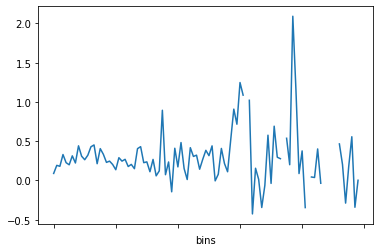

In [115]:
analysis.groupby('bins').mean()['%_gain'].plot()

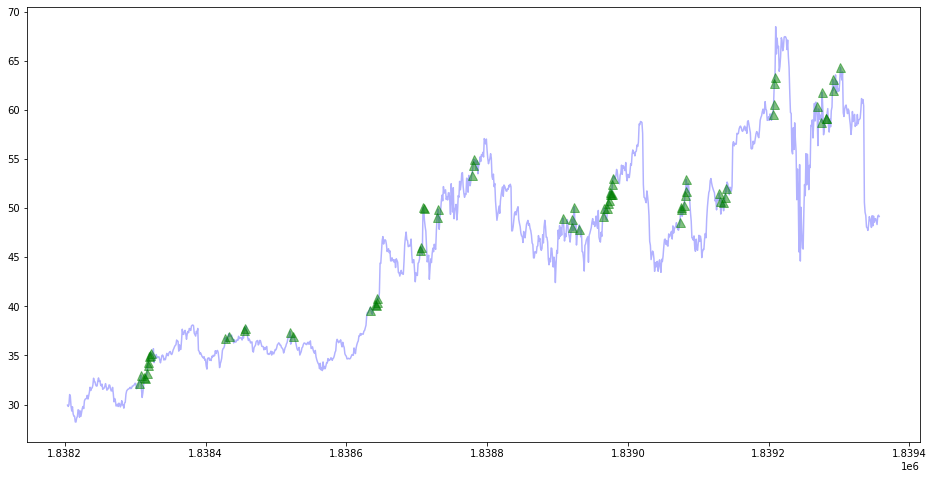

In [23]:
trades[(trades['symbol'] == 'INTC')]['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.3)
trades[(trades['symbol'] == 'INTC') & (trades['macd_bullish_divergence_30d'] == True) &
       (trades['higher_highs_3d'] == True)]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')


In [53]:
trades[f'stationary_sma_{i}d_zscore']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
1857648    0.575926
1857649    0.558447
1857650    0.519373
1857651    0.531487
1857652    0.671827
Name: stationary_sma_200d_zscore, Length: 1857653, dtype: float64

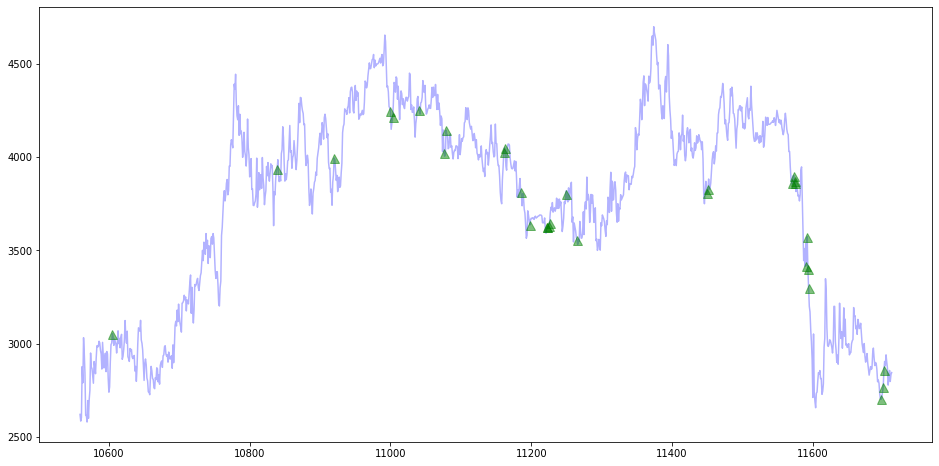

In [61]:
trades[(trades['symbol'] == 'SEB')]['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.3)
trades[(trades['symbol'] == 'SEB') & (trades['sma_20_zscore_cross'] == True)]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
#trades[(trades['symbol'] == 'SEB') & (trades['bb_end_buy_zone'] == True)]['close_price_x'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


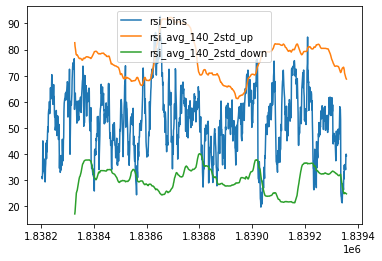

In [28]:
trades['rsi_avg_140_2std_up'] = trades['rsi_avg_140'] + (2 * trades['rsi_std_140'])
trades['rsi_avg_140_2std_down'] = trades['rsi_avg_140'] - (2 * trades['rsi_std_140'])
trades[trades['symbol'] == 'INTC'][['rsi_bins', 'rsi_avg_140_2std_up', 'rsi_avg_140_2std_down']].plot()

In [14]:
trades[trades['rsi_bins_cross_up_35_avg_std2'] == True][['rsi_bins', 'rsi_bins_shift_1d', 'rsi_avg_35', 'rsi_std_35']]

,rsi_bins,rsi_bins_shift_1d,rsi_avg_35,rsi_std_35
102,56.246367,49.179500,47.080758,4.436875
103,58.146862,56.246367,47.191692,4.664464
104,63.379111,58.146862,47.525738,5.362342
199,62.492914,41.246879,44.632714,4.371732
269,70.713066,68.209237,53.782818,8.091177
...,...,...,...,...
1857589,62.492635,56.077633,50.583371,4.393101
1857595,69.890594,64.830562,53.371396,6.989574
1857597,75.264939,71.169480,54.867451,8.221521
1857641,69.007958,65.350679,55.561911,6.105827


- RSI crosses: 30
- RSI below: 80
- RSI growing


In [3]:
symbols = ['COLL', 'STOR', 'CCJ', 'TGTX', 'SAGE']
trades[(trades['buy_signal?5'] == True) &
      (pd.to_datetime(trades['just_date']) < '2018-01-01')][['symbol', 'just_date','rsi_bins', 
                                                              'macd_hist', 'bb_bbh_diff_std', 
                                                              'bb_bbl_diff_std', 'bb_bbm',
                                                              'bb_std', 'close_price_x']]

,symbol,just_date,rsi_bins,macd_hist,bb_bbh_diff_std,bb_bbl_diff_std,bb_bbm,bb_std,close_price_x
63116,TCS,2017-06-23,51.506952,0.136140,-0.912300,3.087700,4.598143,0.746398,5.410000
68103,MHLD,2016-10-20,58.573307,0.018686,-1.580383,2.419617,13.454429,0.466071,13.650000
79112,BITA,2017-04-20,59.131157,0.090644,-0.839348,3.160652,22.282000,2.514106,25.200001
105397,FIZZ,2016-11-25,54.107133,0.684927,-1.457317,2.542683,48.628428,2.490536,49.980000
105441,FIZZ,2017-01-31,57.310436,-0.085713,-1.498986,2.501014,49.193000,1.989961,50.189999
112402,ANIX,2017-11-14,55.357014,-0.053992,-1.271740,2.728260,1.842571,1.081246,2.630000
113970,MDCA,2017-08-14,58.629827,0.071503,-0.409103,3.590897,9.235714,0.888986,10.650000
170713,EPAC,2017-10-09,59.743644,0.247448,-0.572258,3.427742,24.592857,1.160674,26.250000
201090,PBPB,2017-12-07,58.098601,0.109238,-0.211966,3.788034,11.991429,0.480176,12.850000
203834,FRGI,2016-12-12,55.340446,0.232133,-0.697343,3.302657,26.773286,1.824512,29.150000


In [9]:
trades['next_30d_return_boolean'] = False
trades['next_30d_return_boolean'].mask((trades['next_30d_return'] >= 1.05), True, inplace=True)

In [25]:
list(trades.columns[65:235])

['moving_1d_return',
 'moving_2d_return',
 'moving_3d_return',
 'moving_4d_return',
 'moving_5d_return',
 'moving_10d_return',
 'moving_20d_return',
 'sma_10d',
 'sma_10d_shift',
 'sma_10d_shift_5d',
 'sma_10d_coef',
 'sma_10d_coef_shift_3d',
 'sma_10d_coef_shift_5d',
 'sma_10d_coef_shift_10d',
 'sma_20d',
 'sma_20d_shift',
 'sma_20d_shift_5d',
 'sma_20d_coef',
 'sma_20d_coef_shift_3d',
 'sma_20d_coef_shift_5d',
 'sma_20d_coef_shift_10d',
 'sma_50d',
 'sma_50d_shift',
 'sma_50d_shift_5d',
 'sma_50d_coef',
 'sma_50d_coef_shift_3d',
 'sma_50d_coef_shift_5d',
 'sma_50d_coef_shift_10d',
 'sma_100d',
 'sma_100d_shift',
 'sma_100d_shift_5d',
 'sma_100d_coef',
 'sma_100d_coef_shift_3d',
 'sma_100d_coef_shift_5d',
 'sma_100d_coef_shift_10d',
 'sma_200d',
 'sma_200d_shift',
 'sma_200d_shift_5d',
 'sma_200d_coef',
 'sma_200d_coef_shift_3d',
 'sma_200d_coef_shift_5d',
 'sma_200d_coef_shift_10d',
 'sma_10d_20d_ratio',
 'sma_10d_20d_ratio_shift',
 'sma_10d_20d_ratio_shift_2',
 'sma_10d_20d_ratio_sh

In [159]:
peak = trades[trades['just_date'].astype(str) == '2020-02-18']
bottom = trades[trades['just_date'].astype(str) == '2020-03-16']
today = trades[trades['just_date'].astype(str) == '2020-09-01']

peak = peak[['symbol', 'name', 'industry', 'close_price_x']]
peak.columns = ['symbol', 'name', 'industry', 'peak']
bottom = bottom[['symbol', 'close_price_x']]
bottom.columns = ['symbol', 'bottom']
today = today[['symbol', 'close_price_x']]
today.columns = ['symbol', 'today']

In [160]:
analysis = pd.merge(peak, bottom, on='symbol', how='left')
analysis = pd.merge(analysis, today, on='symbol', how='left')
analysis['today_peak'] = analysis['today'] / analysis['peak']
analysis['bottom_peak'] = analysis['bottom'] / analysis['peak']
analysis['difference'] = analysis['today_peak'] - analysis['bottom_peak']

In [163]:
analysis.sort_values('difference').head(100)

,symbol,name,industry,peak,bottom,today,today_peak,bottom_peak,difference
1068,VIR,"Vir Biotechnology, Inc.",Healthcare,17.530001,45.759998,36.340000,2.073018,2.610382,-0.537364
731,NWG,NatWest Group plc,Financial,5.380000,4.630000,2.830000,0.526022,0.860595,-0.334573
928,CIM,Chimera Investment Corporation,Real Estate,22.750000,15.060000,8.843300,0.388716,0.661978,-0.273262
559,AMN,"AMN Healthcare Services, Inc.",Healthcare,75.669998,70.400002,53.880001,0.712039,0.930356,-0.218316
1620,COTY,Coty Inc.,Consumer Defensive,11.540000,5.920000,3.545000,0.307192,0.512998,-0.205806
1297,HSBC,HSBC Holdings plc,Financial,35.820000,28.139999,21.110001,0.589336,0.785595,-0.196259
502,HE,"Hawaiian Electric Industries, Inc.",Utilities,50.299999,43.889999,34.060001,0.677137,0.872565,-0.195427
554,BSMX,Banco Santander Mexico SA ADR,Financial,7.610000,4.610000,3.240000,0.425756,0.605782,-0.180026
223,IFS,Intercorp Financial Services Inc.,Financial,41.810001,31.480000,24.461599,0.585066,0.752930,-0.167864
469,ARVN,"Arvinas, Inc.",Healthcare,49.919998,33.000000,24.680000,0.494391,0.661058,-0.166667


In [12]:
industry = analysis.groupby('industry').mean()['today_peak'].reset_index()
industry.columns = ['industry', 'industry_avg']
industry_std = analysis.groupby('industry').std()['today_peak'].reset_index()
industry_std.columns = ['industry', 'industry_std']
industry = pd.merge(industry, industry_std, on='industry')
industry['below_1std'] = industry['industry_avg'] - (1 * industry['industry_std'])
industry['above_1std'] = industry['industry_avg'] + (1 * industry['industry_std'])
industry['below_2std'] = industry['industry_avg'] - (2 * industry['industry_std'])
industry['above_2std'] = industry['industry_avg'] + (2 * industry['industry_std'])

final = pd.merge(analysis, industry, on='industry')
final = final.drop_duplicates()

In [13]:
final[(final['today_peak'] < final['below_1std']) & (final['difference'] > 0)]

,symbol,name,industry,peak,bottom,today,today_peak,bottom_peak,difference,industry_avg,industry_std,below_1std,above_1std,below_2std,above_2std
29,NCMI,"National CineMedia, Inc.",Communication Services,7.870000,3.110000,3.160000,0.401525,0.395172,0.006353,1.021270,0.566662,0.454607,1.587932,-0.112055,2.154594
105,FTSI,"FTS International, Inc.",Energy,27.799999,5.400000,5.940000,0.213669,0.194245,0.019424,0.734255,0.308917,0.425339,1.043172,0.116422,1.352089
126,NINE,"Nine Energy Service, Inc.",Energy,5.620000,0.910000,1.670000,0.297153,0.161922,0.135231,0.734255,0.308917,0.425339,1.043172,0.116422,1.352089
137,SNDE,Sundance Energy Inc.,Energy,9.575000,1.000000,2.380000,0.248564,0.104439,0.144125,0.734255,0.308917,0.425339,1.043172,0.116422,1.352089
151,USWS,"U.S. Well Services, Inc.",Energy,1.260000,0.390000,0.410000,0.325397,0.309524,0.015873,0.734255,0.308917,0.425339,1.043172,0.116422,1.352089
155,ICD,"Independence Contract Drilling, Inc.",Energy,11.060000,1.470000,3.000000,0.271248,0.132911,0.138336,0.734255,0.308917,0.425339,1.043172,0.116422,1.352089
158,VIST,"Vista Oil & Gas, S.A.B. de C.V.",Energy,7.440000,2.670000,3.100000,0.416667,0.358871,0.057796,0.734255,0.308917,0.425339,1.043172,0.116422,1.352089
160,SMLP,"Summit Midstream Partners, LP",Energy,2.360000,0.900000,0.920000,0.389831,0.381356,0.008475,0.734255,0.308917,0.425339,1.043172,0.116422,1.352089
191,HP,"Helmerich & Payne, Inc.",Energy,45.070000,14.560000,18.570000,0.412026,0.323053,0.088973,0.734255,0.308917,0.425339,1.043172,0.116422,1.352089
217,CAAP,Corporacion America Airports S.A.,Industrials,5.230000,1.780000,2.520000,0.481836,0.340344,0.141491,0.973345,0.352410,0.620934,1.325755,0.268524,1.678166


## Look at suggested trades

In [3]:
def show_me_trades(no_of_days, buy_signal, clean_data):
    
    # Define min date
    min_date = clean_data['timestamp'].max() - timedelta(days=no_of_days)
    
    relevant_columns = ['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']

    # Create Metrics
    metrics = clean_data[(clean_data[buy_signal] == True)][relevant_columns]
    metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
    metrics_a = metrics.groupby(['symbol', 'name', 'industry', 'year']).count()['timestamp'].reset_index()
    metrics_b = metrics.groupby(['symbol', 'name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
    metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

    # Create set of good symbols
    list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2019)]['symbol'])

    # Run for the past 5 days
    print('Only with past record')
    display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
    print('Everything')
    display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

    # Last days buys
    last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True) & (clean_data['symbol'].isin(list_of_good))]['symbol'])
    display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

In [4]:
show_me_trades(1, 'buy_signal?7', trades)


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
1042127,2020-08-07 17:00:13,MRCY,NaN,NaN,NaN,79.849998
1427541,2020-08-07 17:00:03,CAE,NaN,NaN,NaN,15.190000
1924914,2020-08-07 17:00:13,HR,NaN,NaN,NaN,29.590000
2210726,2020-08-07 17:00:17,FANG,NaN,NaN,NaN,41.180000
2300984,2020-08-07 16:59:41,SLM,NaN,NaN,NaN,6.945000
2577634,2020-08-07 17:00:40,MOMO,NaN,NaN,NaN,19.700001


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
157024,2020-08-07 16:59:24,TDY,NaN,NaN,NaN
1042127,2020-08-07 17:00:13,MRCY,NaN,NaN,NaN
1427541,2020-08-07 17:00:03,CAE,NaN,NaN,NaN
1830523,2020-08-07 17:00:40,ORCC,NaN,NaN,NaN
1924914,2020-08-07 17:00:13,HR,NaN,NaN,NaN
2210726,2020-08-07 17:00:17,FANG,NaN,NaN,NaN
2300984,2020-08-07 16:59:41,SLM,NaN,NaN,NaN
2577634,2020-08-07 17:00:40,MOMO,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
326,CAE,CAE Inc.,Industrials,2020,8,1.262861,1.107829,1.030023
705,FANG,"Diamondback Energy, Inc.",Energy,2017,5,1.047587,1.030084,0.950954
706,FANG,"Diamondback Energy, Inc.",Energy,2019,18,0.978954,0.990966,1.009787
707,FANG,"Diamondback Energy, Inc.",Energy,2020,16,1.121416,1.118168,1.211479
925,HR,Healthcare Realty Trust Incorporated,Real Estate,2017,5,1.000964,1.005981,0.981463
926,HR,Healthcare Realty Trust Incorporated,Real Estate,2018,15,0.992104,0.983667,0.989573
927,HR,Healthcare Realty Trust Incorporated,Real Estate,2020,11,1.024431,1.043149,1.050647
1259,MOMO,Momo Inc.,Communication Services,2020,22,0.937483,0.913135,0.919014
1258,MOMO,Momo Inc.,Communication Services,2019,11,1.075100,1.063011,1.079157
1256,MOMO,Momo Inc.,Communication Services,2017,4,0.852150,0.844021,0.911704


## Explore a Security Further

In [22]:
def create_charts_1(df, symbol, field='close_price_x', include_sell=True, what_to_print=[1,2,3,4,5]):
    # Filter using the symbol
    snap_df = df[(df['symbol'] == symbol)]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    
    # Buy and Sell Signals 
    if 1 in what_to_print:
        snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    if 2 in what_to_print:
        snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    if 3 in what_to_print:
        snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    if 4 in what_to_print:
        snap_df[snap_df['buy_signal?4'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 4')
    if 5 in what_to_print:
        snap_df[snap_df['buy_signal?5'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 5')
    if 6 in what_to_print:
        snap_df[snap_df['buy_signal?7'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 6')
    if 7 in what_to_print:
        snap_df[snap_df['buy_signal?7'] == True][field].plot(linestyle='', marker='^', color='red', alpha = 0.75, markersize = 9, label='Buy Signal 7')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?1'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    if field == 'close_price_x':
        snap_df['sma_200d'].plot(color='red', alpha = 0.5, markersize = 7, label='200d')
        snap_df['sma_50d'].plot(color='green', alpha = 0.5, markersize = 7, label='50d')
        snap_df['sma_20d'].plot(color='black', alpha = 0.4, markersize = 7, label='20d')
        #snap_df['sma_10d'].plot(color='pink', alpha = 1, markersize = 7, label='10d')
    elif field == 'macd_line':
        snap_df['macd_signal_line'].plot(color='green', alpha = 0.5, markersize = 7, label='signal_line')

    # Title
    plt.title((symbol + ' - Buy/Sell Signals using ' + field), fontsize=15)
    plt.legend()
    
    plt.show();
              

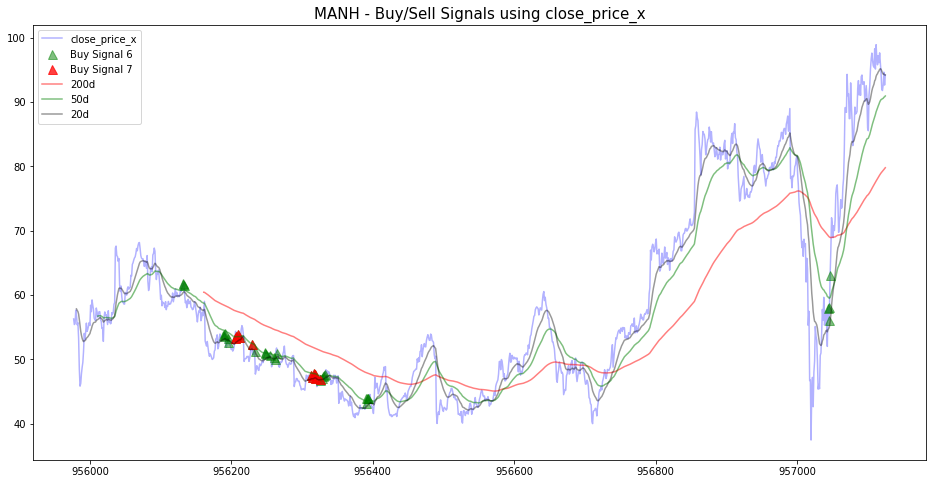

In [30]:
create_charts_1(trades, 'MANH', what_to_print=[7,6], include_sell=False)

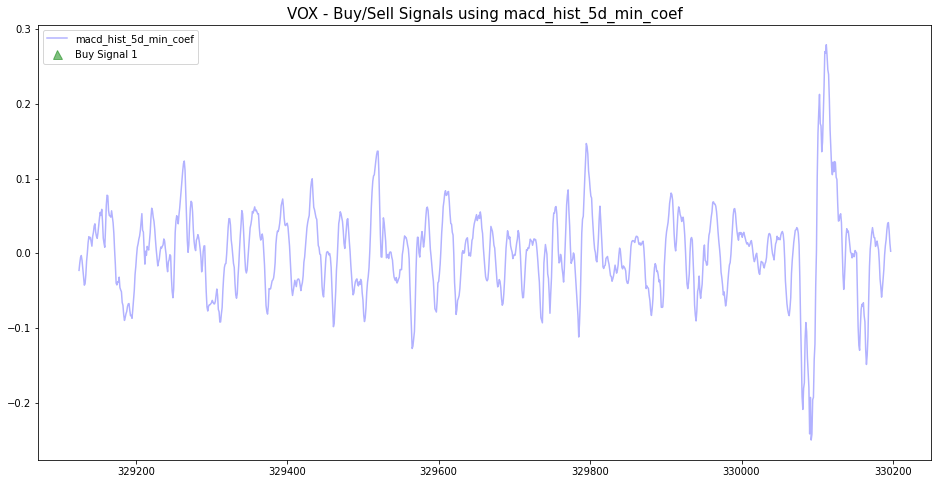

In [20]:
create_charts_1(trades, 'VOX', what_to_print=[1], include_sell=False, field='macd_hist_5d_min_coef')

In [ ]:
create_charts_1(trades, 'ABMD', what_to_print=[1], include_sell=True, field='macd_line')

In [ ]:
create_charts_1(trades, 'DOX', what_to_print=[4], include_sell=False, field='sma_50d_100d_ratio_shift_10')

In [ ]:
create_charts_1(trades, 'EQC', what_to_print=[1], include_sell=False, field='macd_line_5d_min_coef')

In [3]:
from extract.price_extract import main_prices
from extract.fundamentals import main_fundamentals
from extract.market_cap import main_market_cap
from indicators.indicators import main_indicators, run_indicators
from signals.create_signals import main_signals
from indicators.benchmarks import benchmark_prices

In [4]:
all_prices, my_stocks_symbols = main_prices(full_refresh=True)

1758 stocks will be analyzed

Running Full Refresh


In [5]:
benchmark_and_prices, benchmarks_columns = benchmark_prices(all_prices)

In [6]:
lstt = []
run_indicators(benchmark_and_prices, lstt, 'BRK-A', benchmarks_columns)

In [6]:
my_stocks_symbols[0][0]

'BRK-A'